# Voices of Australia: Unveiling Hidden Insights in Radio Talk  
### ANLP AT1
#### August 28, 2024
#### Arjun Khanijau 13478401


Australian radio is a vibrant space where everyday conversations reflect the heartbeat of a nation. From health discussions to gardening tips, radio talk shows offer a glimpse into what’s on the minds of Australians. This project taps into these conversations, using text analysis to uncover hidden patterns, regional differences, and key themes that drive the national dialogue. By analyzing these diverse topics, we unlock valuable insights into the stories Australians are sharing across the airwaves.

# **Dataset Description**

The dataset consists of 29 plain text files, each representing a transcript of Australian radio talkback recordings. The files are divided into two main categories: transcripts from ABC Radio and commercial radio stations.

1. **ABC Radio Transcripts:**
   - **NAT (National):** 8 transcribed recordings from ABC National Radio.
   - **ABCE (Eastern):** 4 transcribed recordings from ABC Radio broadcasts to eastern Australia.
   - **ABCNE (Southern and Western):** 2 transcribed recordings from ABC Radio broadcasts to southern and western Australia.

2. **Commercial Radio Transcripts:**
   - **COME (Eastern):** 8 transcribed recordings from commercial stations broadcasting to eastern Australia.
   - **COMNE (Southern and Western):** 7 transcribed recordings from commercial stations broadcasting to southern and western Australia.


# **Additional Data Used: 1) Australian Slang Dictionary**

## **Web Scraping for Australian Colloquial/Slang Terms**

To accurately process Australian radio talk transcripts, it's essential to handle colloquial terms unique to the region. We extracted Australian slang terms and their meanings from https://nomadsworld.com/aussie-slang/.

**Process:**
1. **Web Scraping**: Used Python’s `requests` and `BeautifulSoup` libraries to extract slang terms and their meanings from the website. A retry mechanism ensured successful data retrieval, accounting for potential issues like network errors.
   
2. **Custom Additions:** Additional slang terms, like "schoolies," were identified during the text analysis and manually added to the dictionary with context-specific meanings.

3. **Data Cleaning:** The extracted data was cleaned to remove extraneous text, ensuring the slang dictionary is accurate and properly formatted.


# 2) Plant Names from Gardening Dictionary

As another supplementary dataset, plant names were sourced from the **Better Homes & Gardens Gardening Plant Dictionary** (https://www.bhg.com/gardening/plant-dictionary/). These plant names were scraped from the website to enhance the analysis of gardening-related discussions within the Australian radio transcripts.

The extraction process followed a similar approach to the Australian slang dictionary dataset, where web scraping techniques were employed to collect plant names. This dataset enabled the cross-referencing of specific plant species mentioned in the radio conversations, offering deeper insights into gardening trends and plant preferences discussed across the radio shows.


### Biomedical Corpora: BC5CDR and BIONLP13CG

The **BC5CDR** and **BIONLP13CG** corpora were leveraged indirectly through the pre-trained spaCy NER model. These corpora, which consist of biomedical and clinical text annotated with disease and chemical entities, were used to facilitate the extraction of disease-related entities from the radio transcripts. This process allowed us to identify medical terms and analyze health-related topics discussed in the Australian radio shows.

While the BC5CDR and BIONLP13CG corpora were not directly used as datasets, they played a crucial role in enhancing the health-related text analysis by providing a specialized model for extracting relevant disease entities.


# **High-Level Project Steps:**

1. **Web Scraping and Colloquial Analysis**: Scraped the Australian slang dictionary from online sources and analyzed colloquial language and slang to account for region-specific terms.

2. **Basic Preprocessing**: Applied standard preprocessing techniques such as tokenization, stopword removal, lowercasing, and punctuation stripping to prepare the text for deeper analysis.

3. **Conversation-Specific Preprocessing**: Implemented tailored preprocessing steps to handle disfluencies, filler phrases, and conversational quirks typical in radio talkback shows, ensuring cleaner data.

4. **Unlocking the Stories Hidden in Text: Exploring Themes Through Topic Modeling**: Used topic modeling techniques like Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF) to uncover underlying themes in the radio conversations.

5. **Comparison of LDA vs. NMF**: Compared the performance and insights gained from LDA and NMF to determine which method provided clearer and more coherent topics in the text.

6. **Comparison of Regional Topic Prevalence Across Australia**: Analyzed topic prevalence across different regions (National vs Eastern vs Southern/Western Australia) to understand regional variations in conversation themes.

7. **Topic-Specific Research Questions**: Developed targeted research questions based on the identified topics.

**Visualizations** like an interactive Sankey diagram, word clouds, network graphs, and bar charts bring the text analysis to life.

# **Research Questions**

After identifying key topics in the Australian radio transcripts, the following research questions were developed to guide deeper analysis and uncover meaningful insights:

- **What are the most frequently mentioned medical terms in the 'Health & Medicine' topic?**

- **How do key medical terms in the 'Health & Medicine' topic co-occur, and what are the significant relationships between them?**

- **Which type of cancer sparks the most discussion in the 'Health & Medicine' topic?**

- **How are the concepts of education and funding discussed together, and what concerns or themes emerge from their intersection?**

- **How do national, religious, and political groups interact within the 'Social Events & Interactions' topic, and which entities are most commonly linked together?**

- **How do plant preferences vary in the 'Gardening' topic, and which plants are mentioned most frequently across all documents?**

- **How do plant preferences differ between the Eastern and Southern/Western regions in the 'Gardening' topic?**


Import necessary libraries for text analysis and visualizations

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import spacy
import seaborn as sns
from itertools import combinations
import networkx as nx
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

Building the Australian slang dictionary through web scraping

In [2]:
# URL of the website to extract Australian colloquial terms and their meanings
url = "https://nomadsworld.com/aussie-slang/"

slang_dict = {}

# Run the loop until slang_dict is not empty
while not slang_dict:
    # Send a GET request to fetch the HTML content of the page with proper encoding
    response = requests.get(url)
    response.encoding = 'utf-8'
    html_content = response.text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the section containing the slang terms and meanings
    slang_list = soup.find('ol')

    # Check if the list was found
    if slang_list:
        # Iterate over each <li> item in the list
        for item in slang_list.find_all('li'):
            strong_tag = item.find('strong')
            if strong_tag:
                slang_term = strong_tag.get_text(strip=True)
                # Extract the meaning by removing the slang term from the list item text
                meaning = item.get_text(strip=True).replace(slang_term, '').replace('–', '').strip()
                # Replace any unwanted non-ASCII characters
                meaning = meaning.replace('Â', '').replace('\u00a0', ' ').strip()
                slang_dict[slang_term] = meaning

# Custom words found during text analysis but not present in the url
custom_words = {
    "Schoolies": "End-of-school celebration for Year 12 students",
}

# Add custom words to the slang dictionary
slang_dict.update(custom_words)

# Display the complete slang dictionary with both scraped and custom words
for slang, meaning in slang_dict.items():
    print(f"{slang}: {meaning}")

A Cold One: Beer
Accadacca: How Aussies refer to Australian band ACDC
Ankle Biter: Child
Arvo: Afternoon (S’ this afternoon!)
Aussie Salute: Wave to scare the flies
Avo: cado
Bail: To cancel plans. ‘Bruce bailed’ = Bruce isn’t going to turn up.
Barbie: Barbecue
Bathers: Swimsuit
Beauty: !  Great! Most often exclaimed as “You ”
Billabong: A pond in a dry riverbed
Billy: Teapot (In the Outback on the fire)
Bloody: Very. Used to extenuate a point
Bloody oath: yes or its true. “You right mate?”… “Bloody Oath”
Bludger: Someone who’s lazy, generally also who relies on others (when it’s someone who relies on the state they’re often called a ‘dole bludger’)
Bogan: This word is used for people who are, well let’s say, rednecks. Or, if you like, just call your friends a bogan when they are acting weird.
Booze Bus: Police vehicle used to catch drunk drivers
Bottle-O: Bottle Shop, basically a place to buy alcohol
Brekky: Breakfast
Brolly: Umbrella
Bruce: An Aussie Bloke
Buckleys Chance: little cha

Mount Google Drive

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Files into a Corpus

In [4]:
# Define the path to folder in Google Drive
folder_path = '/content/drive/My Drive/AT1_dataset_AusRadioTalkback'

# Initialize an empty dictionary to hold the corpus
corpus_dict = {}

# Loop through each text file in the folder and store the content in the corpus dictionary
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            content = file.read()
            corpus_dict[filename] = content

Now, corpus_dict is a dictionary where keys are filenames and values are the text content

Check if all 29 files are loaded into the corpus dictionary

In [5]:
if len(corpus_dict) == 29:
    print("All 29 files have been successfully loaded into the corpus.")
else:
    print(f"Warning: {len(corpus_dict)} files were loaded. There may be missing files.")

All 29 files have been successfully loaded into the corpus.


In [6]:
# Convert slang dictionary keys to lowercase
slang_dict = {key.lower(): value.lower() for key, value in slang_dict.items()}


# Initialize a counter to hold slang word frequencies
slang_counter = Counter()

# Iterate through the corpus dictionary to count slang occurrences and collect sentences
for filename, text in corpus_dict.items():
    # Convert the corpus text to lowercase
    text_lower = text.lower()
    # Split text into sentences
    sentences = re.split(r'[.!?]', text_lower)
    for slang, meaning in slang_dict.items():
        # Use regular expression to match the slang as a whole word
        pattern = r'\b' + re.escape(slang) + r'\b'
        if re.search(pattern, text_lower):
            slang_counter[slang] += len(re.findall(pattern, text_lower))

In [7]:
slang_counter

Counter({'bloody': 13,
         'going off': 5,
         'no worries': 15,
         'pash': 2,
         'reckon': 33,
         'sick': 19,
         'esky': 2,
         'heaps': 10,
         'stubby': 1,
         'slab': 4,
         'beauty': 4,
         'tea': 11,
         'bush': 24,
         'rooted': 1,
         'ya': 16,
         'chook': 9,
         'skull': 1,
         'fair dinkum': 2,
         'footy': 17,
         'hoon': 1,
         'crook': 4,
         'runners': 1,
         'servo': 2,
         'tinny': 1,
         'cactus': 1,
         'tucker': 1,
         'good on ya': 1,
         'bathers': 1,
         'stoked': 1,
         'pissed': 1,
         'pissed off': 1,
         'bloody oath': 1,
         'schoolies': 1})

Let's examine the slang terms and their frequencies with a bar chart, followed by visualizing them using a word cloud

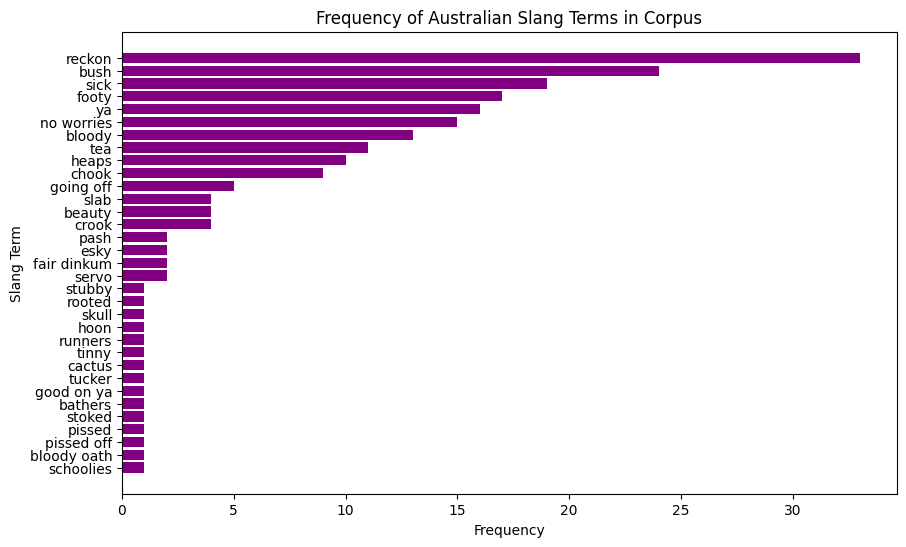

In [8]:
# Sort the slang terms by frequency
sorted_slang = sorted(slang_counter.items(), key=lambda item: item[1], reverse=True)

# Unpack the sorted slang terms and their frequencies
slangs, counts = zip(*sorted_slang)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(slangs, counts, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Slang Term')
plt.title('Frequency of Australian Slang Terms in Corpus')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent slang on top
plt.show()

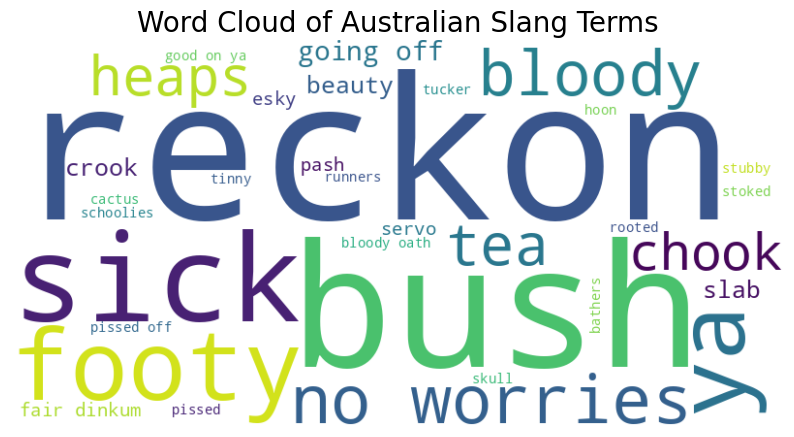

In [9]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(slang_counter)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Australian Slang Terms', fontsize=20)
plt.show()


### **Ambiguous Slang**

After looking at the above 2 visualizations, the word 'sick' appears frequently in the text. Let's review the sentences containing this word to determine whether it's being used in its slang sense or in another context.

In [10]:
# Slang term to search for
target_slang = 'sick'

# Initialize a list to hold sentences containing the slang term 'sick'
sick_sentences = []

# Iterate through the corpus dictionary to find sentences containing the slang 'sick'
for filename, text in corpus_dict.items():
    text_lower = text.lower()
    # Split text into sentences
    sentences = re.split(r'[.!?]', text_lower)
    # Define the pattern to match the slang term 'sick' as a whole word
    pattern = r'\b' + re.escape(target_slang) + r'\b'
    for sentence in sentences:
        if re.search(pattern, sentence):
            sick_sentences.append(sentence.strip())

# Print the sentences containing the slang 'sick'
print(f"Sentences containing '{target_slang}':\n")
for sentence in sick_sentences:
    print(f"- {sentence}")


Sentences containing 'sick':

- it's a good song isn't it brand new on triple j super request and sick transit gloria and also deep child and the blackness of the sea one-eight-hundred-oh-triple-five-three-six it is trivia thursday and tonight we'll attack a a few questions like   the strongest muscle in the human body and how many people choke on ballpoint pens every year
- sam you're a sick man in uh i don't mean i mean that literally you've got the flu
- 'cos nat the rat's sick tonight too
- um she f gets a friend they have slightly different versions but you know come together in the same version i mean it made me feel a bit sick the first time i read it i thought this is wrong this is
- one thing about it in its acute phase it is you are sick
- when  you have polymyalgia rheumatica you look sick you feel sick you feel absolutely miserable
- in now at that stage i was sick quite a lot and couldn't keep anything down for months  and had bile  so last night i was sick again and it di


**Findings**: A manual review of the sentences containing "sick" confirmed that in all instances, the term was used to mean "unwell" rather than its slang meaning of "awesome." Due to this consistent use, "sick" was removed from the slang dictionary to prevent any misinterpretation in the analysis.

In [11]:
# Remove 'sick' from the slang dictionary
slang_dict.pop('sick', None)

# Remove 'sick' from the slang counter
slang_counter.pop('sick', None)


19

Now we'll get the top 5 most frequent slang terms along with their meanings from the slang dictionary and visualize the corrected word cloud:


In [12]:
# Get the top 5 most frequent slang terms
top_5_slangs = slang_counter.most_common(5)

# Print the top 5 slang terms with their meanings
print("Top 5 Slang Terms and Their Meanings:\n")
for slang, count in top_5_slangs:
    meaning = slang_dict.get(slang, "Meaning not found") ## Error handling
    print(f"'{slang}' - {meaning} ({count} occurrences)")


Top 5 Slang Terms and Their Meanings:

'reckon' - for sure. ‘you ?’… ‘i reckon!’ (33 occurrences)
'bush' - “out in the bush”  “he’s gone bush” in the countryside away from civilisation (24 occurrences)
'footy' - football (afl / aussie rules) (17 occurrences)
'ya' - you (16 occurrences)
'no worries' - no problem / it’s ok (15 occurrences)


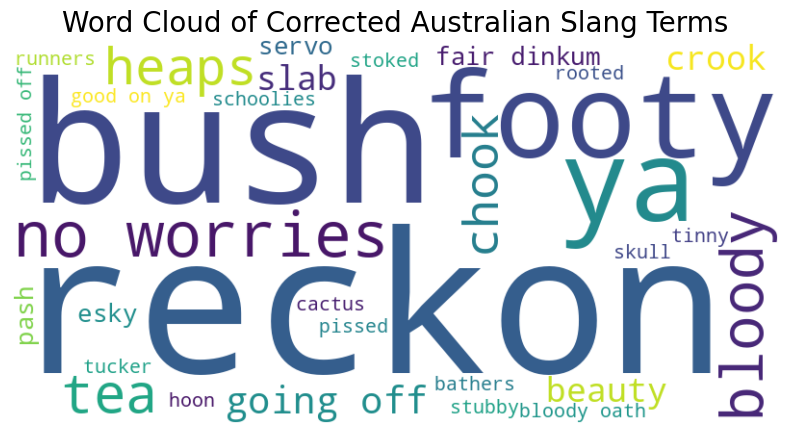

In [13]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(slang_counter)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Corrected Australian Slang Terms', fontsize=20)
plt.show()


**The Aussie airwaves are buzzing with some classic slang! Here are the top 5 contenders:**

**1. 'reckon' - The go-to affirmation down under. Heard it 33 times, so you know it's a sure thing!**

**2. 'bush' - Not just any countryside—it's the wild, untamed heart of Australia, mentioned 24 times!**

**3. 'footy' - No soccer or rugby here, mate. It's all about Aussie Rules Football, with 17 shout-outs.**

**4. 'ya' - Because why say 'you' when 'ya' is just as good? (16 times, and counting).**

**5. 'no worries' - The ultimate chill pill. Heard 15 times, because in Australia, everything’s always 'no worries'!**










# Basic Text Preprocessing Steps

1. **Lowercasing** - Convert all text to lowercase to ensure uniformity.

2. **Remove Punctuation and Special Characters** - Strip out all punctuation and special characters, leaving only alphabetic characters and spaces.

3. **Tokenization** - Split the text into individual words or tokens.

4. **Remove Stopwords and Lemmatize** - Remove common stopwords (e.g. 'the',  'of', etc.) and reduce words to their base or root form using lemmatization.

5. **Reconstruct Text** - Join the processed tokens back into a single string for further use.


In [14]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Basic preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join words back into a single string
    processed_text = ' '.join(words)

    return processed_text

# Apply preprocessing to each document in the corpus_dict
for filename in corpus_dict:
    raw_text = corpus_dict[filename]
    processed_text = preprocess_text(raw_text)
    corpus_dict[filename] = processed_text

#  Display the first 500 characters of a processed document
for filename, processed_text in corpus_dict.items():
    print(f"Processed content of {filename}:\n")
    print(processed_text[:500])
    print("\n---\n")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed content of NAT1-plain.txt:

oneeighthundredeightohtwothreefourone let go melbourne annemarie welcome australia talk back oh hi yeah good thank um wanted put thought forward um cut um education university fee oh hecs funding yep yep yeah um thought uh another repercussion noones really thought student whove free education feel urge obligation give something back community um think brendan nelson expressed worry education paid tax working class perhaps hed paid paid education wouldnt actually felt um freedom urge go politics

---

Processed content of NAT2-plain.txt:

speaking welcome people love ramona koval welcome back thank sandy lovely back youre right great warm hearted book full luck fate fish gambling n anzac youd like say program join um online discussion b c dot net dot u slash r n follow link australia talk book phone u id like phone u wan na talk oneeighthundredeightohtwothreefourone oneeighthundredeightohtwothreefourone also joining u second time australia talk boo

# Preprocessing Function with Conversation-Specific Enhancements



After going through a sample of the corpus following the basic preprocessing, several issues were identified that required additional conversation-specific preprocessing:

1. **Presence of Redundant Phrases and Announcements**:
   The text contained many instances of greetings, acknowledgments, and repetitive phrases that are common in conversations but do not add value to the analysis.
   - **Example Words/Phrases**: "good morning", "welcome", "thank you", "hello".
   - **Justification**: These phrases are standard conversational fillers and do not contribute meaningfully to understanding the content. Removing them reduces noise and focuses the analysis on the substantive parts of the text.

2. **Inclusion of Specific Contact Information and Service Numbers**:
   The transcripts included references to phone numbers, service codes, and other specific contact information that are irrelevant to most analyses.
   - **Example Words/Phrases**: "one-eight-hundred", "five-five-five", "call us at".
   - **Justification**: Such information is specific to the context of the conversation (e.g., radio show interactions) and does not help in textual analysis. Removing these elements ensures that only relevant content is analyzed.

3. **Repetitive Names and Titles**:
   Names and titles of speakers were frequently repeated, contributing to redundancy without adding value to the analysis.
   - **Example Words/Phrases**: "John", "Dr. Smith", "Mr. Anderson", "says", "joins".
   - **Justification**: Repeated mentions of names and titles can distract from the actual content of the discussion. Removing or reducing the frequency of these mentions helps keep the analysis focused on the key themes of the conversation.

4. **Dialogue Fillers and Disfluencies**:
   The text was filled with common conversational fillers and disfluencies that do not contribute to the meaning of the text.
   - **Example Words/Phrases**: "um", "uh", "n", "you know", "like", "ah".
   - **Justification**: These fillers are natural in spoken language but do not add value in written text analysis. Eliminating them improves the clarity of the text and enhances the quality of subsequent analysis.

5. **Handling Time and Date References**:
   The transcripts included frequent mentions of specific times and dates, which were not relevant to the analysis and could introduce unnecessary variability.
   - **Example Words/Phrases**: "3:00 pm", "on the 15th", "yesterday", "tomorrow".
   - **Justification**: Time and date references are often context-specific and do not contribute to the core content of the conversation. Removing these references ensures a more consistent and relevant dataset for analysis.

6. **Removal of Contractions**:
   The basic preprocessing did not address contractions, leading to potential inconsistencies in the text.
   - **Example Words/Phrases**: "youre", "dont", "cant".
   - **Justification**: Removing contractions ensures that non-standard forms are eliminated, which helps in reducing noise and improving the consistency of the text for accurate analysis and interpretation.


In [15]:
def conversation_specific_preprocessing(text):
    # Remove specific contact information and generic service numbers
    text = re.sub(r'\b(one|oh|zero|eight|three|two|four|five|six|seven|nine)[a-z]*\b', '', text)  # Replace word numbers
    text = re.sub(r'\b(\d+)\b', '', text)  # Remove digits that might represent phone numbers

    # Handle redundant phrases and announcements
    redundant_phrases = [
        r'\bgood morning\b', r'\bgood afternoon\b', r'\bgood evening\b', r'\bhello\b', r'\bwelcome\b', r'\bthank\b',
        r'\bthanks\b', r'\bhi\b', r'\byep\b', r'\buh\b', r'\bum\b', r'\bokay\b', r'\bmorning\b', r'\bafternoon\b',
        r'\bevening\b', r'\bgday\b', r'\byeah\b', r'\bok\b', r'\boh\b', r'\byeah\b', r'\bmhm\b', r'\bhey\b'
    ]
    for phrase in redundant_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)

    # Remove contractions and common uninformative words
    contractions_and_uninformative = {
        "im", "ill", "ive", "youre", "youll", "weve", "dont", "wont", "youve",
        "cant", "isnt", "aint", "wanna", "gonna", "noones", "whove", "hed",
        "wouldnt", "mightve", "youd", "howre", "gon na", "didnt", "whats",
        "doesnt", "havent", "lets", "theyve", "wouldve", "shouldve",
        # Adding common uninformative words
        "think", "got", "thats", "yes", "know", "say", "really",
        "year", "little", "thing", "right", "look", "need", "mean",
        "actually", "time", "going", "people", "theyre", "let",
        "australia", "australians", "australian", "absolutely"
    }
    for word in contractions_and_uninformative:
        text = re.sub(r'\b' + word + r'\b', '', text)

    # Remove repeated names and titles (Assuming they are followed by some common words like "says" or "joins")
    text = re.sub(r'\b([A-Z][a-z]+)\s(says|joins|tells|asks)\b', '', text)

    # Eliminate conversation fillers
    fillers = [
        r'\buh\b', r'\bum\b', r'\boh\b', r'\byeah\b', r'\bwell\b', r'\bgood\b', r'\buh-huh\b', r'\buh huh\b', r'\bum-hmm\b', r'\bum hmm\b', r'\bmhm\b',
        r'\bmm\b', r'\bam\b', r'\bpm\b', r'\bn\b', r'\byknow\b', r'\blike\b', r'\bah\b', r'\ber\b', r'\bem\b'
    ]
    for filler in fillers:
        text = re.sub(filler, '', text, flags=re.IGNORECASE)

    # Handle time and date references
    text = re.sub(r'\b(\d{1,2})[.:](\d{2})\b', '', text)  # Remove time references (e.g., 12:30)
    text = re.sub(r'\b(\d{1,2})(st|nd|rd|th)?\b', '', text)  # Remove ordinal dates (e.g., 23rd, 5th)

    # Remove single alphabet characters
    text = re.sub(r'\b[a-zA-Z]\b', '', text)

    # Clean up any extra whitespace that might have been introduced
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [16]:
# Apply the conversation-specific preprocessing to each document in the corpus_dict
for filename in corpus_dict:
    processed_text = corpus_dict[filename]
    # Apply the conversation-specific preprocessing
    processed_text = conversation_specific_preprocessing(processed_text)
    # Update the corpus_dict with the fully processed text
    corpus_dict[filename] = processed_text

# Display the first 500 characters of the processed document after both preprocessing steps
for filename, processed_text in corpus_dict.items():
    print(f"Processed content of {filename}:\n")
    print(processed_text[:500])  # Display the first 500 characters
    print("\n---\n")

Processed content of NAT1-plain.txt:

go melbourne annemarie talk back wanted put thought forward cut education university fee hecs funding thought another repercussion thought student free education feel urge obligation give something back community brendan nelson expressed worry education paid tax working class perhaps paid paid education felt freedom urge go politics ideal could work towards felt obliged go earn money keep interesting thought annemarie much indeed ron sylvia sydney sydney sih relocated canberra sydney go sylvia t

---

Processed content of NAT2-plain.txt:

speaking love ramona koval back sandy lovely back great warm hearted book full luck fate fish gambling anzac program join online discussion dot net dot slash follow link talk book phone id phone wan na talk also joining second talk book tim winton perth tim nice nice nice back wherever disembodied voice universe nice back tim sandy start reading gunna gunna read bit gunna pleasure listen beautiful big book start k

### The preprocessing removed specific contact information, redundant phrases, repeated names and titles, conversation fillers, and time/date references, resulting in cleaner text data that is more focused on the actual content of the discussions.

# Unlocking the Stories Hidden in Text: Exploring Themes Through Topic Modeling

### TF-IDF Vectorization

- **max_df=0.75**: Filters out terms appearing in more than 75% of documents to remove overly common words.
- **min_df=5**: Excludes terms appearing in fewer than 5 documents to remove rare, potentially irrelevant words.
- Converts `corpus_dict` into a TF-IDF matrix, focusing on terms that are meaningful for analysis, as TF-IDF captures both the frequency of terms and their importance across the document set, making it more informative than simple term counts.


### Justifications:
- `max_df` and `min_df` are set to filter out both very common and very rare words, focusing on terms that provide meaningful differentiation between documents.
- This approach balances removing noise (common/rare words) with keeping informative content, optimizing the dataset for further analysis like clustering or topic modeling.


In [17]:
# Convert the corpus_dict to a list of documents
documents = list(corpus_dict.values())

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5)

# Fit and transform the documents into TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get the feature names (terms) for later use
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Inspect the shape of the matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


TF-IDF Matrix Shape: (29, 1538)


### Comparing Topic Modeling: LDA vs NMF

When comparing LDA and NMF, we'll be using 5 topics and 10 top words to allow for a direct, side-by-side analysis of how each model defines and differentiates these topics, aiding in understanding the strengths and weaknesses of each approach.

We'll apply both Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) to the TF-IDF matrix to extract 5 topics from the documents. Both methods generate a document-topic distribution and a topic-term distribution. The top 10 words for each identified topic are displayed, allowing for a comparison of how each model defines and differentiates these topics, making them interpretable.



In [18]:
# Set the number of topics
n_topics = 5

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10, learning_method='online')

# Fit and transform the data
lda_W = lda_model.fit_transform(tfidf_matrix)  # Document-topic distribution
lda_H = lda_model.components_  # Topic-term distribution

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words, model_name="Model"):
    print(f"Topics generated by {model_name}:")
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")


no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda_model, tfidf_feature_names, no_top_words, model_name="LDA")

Topics generated by LDA:
Topic 0:
book bird value party university paint queensland education school childrens


Topic 1:
book price property student movie twenty school house twelve game


Topic 2:
tonight mark song band friday birthday video bag radio thursday


Topic 3:
plant tree flower leaf garden fruit green pot root water


Topic 4:
doctor water dr tonight woman test blood feel government world




In [19]:
# Apply NMF
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_W = nmf_model.fit_transform(tfidf_matrix)  # Document-topic matrix
nmf_H = nmf_model.components_  # Topic-term matrix


# Display the top words in each topic
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(nmf_model, tfidf_feature_names, no_top_words, model_name="NMF")


Topics generated by NMF:
Topic 0:
tonight song party government john issue guy woman friend world


Topic 1:
plant tree flower garden water leaf fruit pot root grow


Topic 2:
book read school reading heaven child novel childrens reader loved


Topic 3:
price property block house buying hill suburb market buy bedroom


Topic 4:
doctor dr test blood cancer symptom disease graham bone woman




### Differences in Themes Observed Using NMF and LDA

- **NMF**: Provides distinct and well-separated themes. For example:
  - **Social Events & Interactions**: Words like *tonight, party, friend*.
  - **Gardening**: Words like *plant, tree, garden*.
  - **Literature & Education**: Words like *book, read, school*.
  - **Property & Real Estate**: Words like *price, property, market*.
  - **Health & Medicine**: Words like *doctor, test, blood*.

  Each theme is focused, with the words in each topic strongly related to a single, coherent theme.

- **LDA**: Shows more blended themes, with some topics combining unrelated concepts. For example:
  - **Education & Nature**: Words like *book, bird, school* appearing together.
  - **Property & Entertainment**: Words like *price, house, movie* in the same topic.
  
  The themes are broader but less distinct, often mixing different areas of discussion under the same topic.

This distinction highlights NMF's ability to generate clearer and more interpretable topics, while LDA captures broader, more overlapping themes.

### Reasons Why NMF Topics Are More Interpretable

- **Additive Nature**: NMF models topics as additive combinations of terms, leading to more distinct and non-overlapping topics.

- **Non-Negativity Constraint**: The non-negativity constraint in NMF ensures that the components (topics) are easily interpretable as they are built from parts that make intuitive sense (e.g., specific themes or topics).

- **Sparse Representation**: NMF often results in a sparser representation, where each topic is represented by a smaller set of high-weighted words, making the themes more clear and focused.

- **Better Topic Separation**: NMF tends to separate topics more effectively because it does not allow for the same word to contribute significantly to multiple topics, unlike LDA which can create overlap in word distributions across topics.


In [20]:
# Function to generate and display a word cloud for a given topic
def display_wordcloud(topic_idx, nmf_H, tfidf_feature_names, num_words=30):
    wordcloud = WordCloud(background_color='white').generate(
        " ".join([tfidf_feature_names[i] for i in nmf_H[topic_idx].argsort()[:-num_words - 1:-1]])
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()


## Visualizing Themes: Bringing Topics to Life with Word Clouds

**Social Events & Interactions**  
Words like *tonight*, *party*, and *friend* capture the essence of lively gatherings and personal connections.

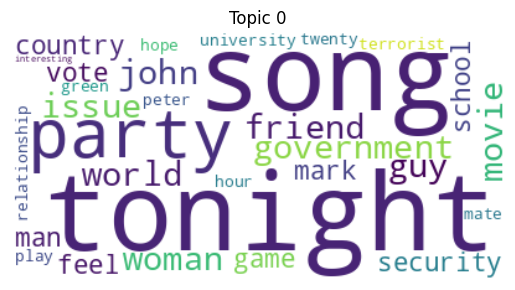

In [21]:
# Word Cloud for Topic 0
display_wordcloud(0, nmf_H, tfidf_feature_names, num_words=30)

**Gardening**  
Words like *plant*, *tree*, and *garden* reflect a serene, green world of outdoor activity and nurturing life.

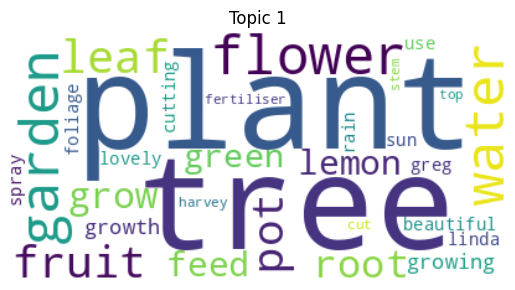

In [22]:
# Word Cloud for Topic 1
display_wordcloud(1, nmf_H, tfidf_feature_names, num_words=30)

**Literature & Education**  
Words like *book*, *read*, and *school* highlight a focus on learning, storytelling, and academic pursuits.

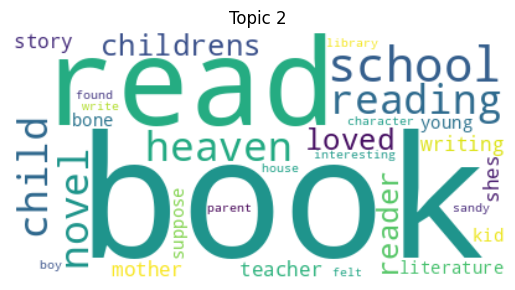

In [23]:
# Word Cloud for Topic 2
display_wordcloud(2, nmf_H, tfidf_feature_names, num_words=30)

**Real Estate**  
Words like *price*, *property*, and *market* emphasize the significance of real estate, home ownership, and the dynamics of the housing market.

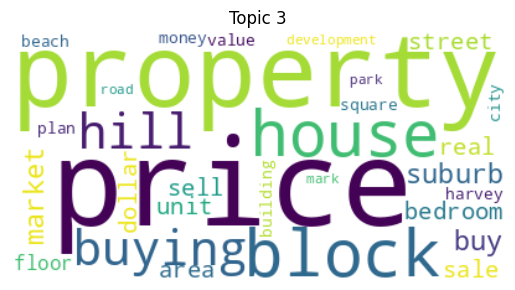

In [24]:
# Word Cloud for Topic 3
display_wordcloud(3, nmf_H, tfidf_feature_names, num_words=30)

**Health & Medicine**  
Words like *doctor*, *test*, and *blood* point to the ever-present concern with health and medical care in our lives.

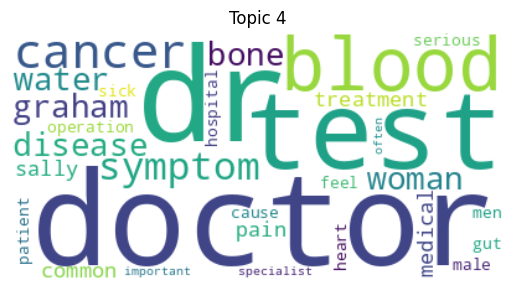

In [25]:
# Word Cloud for Topic 4
display_wordcloud(4, nmf_H, tfidf_feature_names, num_words=30)

# Interactive Sankey Diagram: Exploring Regional Topic Prevalence Across Australia

Map Documents to Regions

In [26]:
# Function to extract region based on filename
def extract_region(filename):
    if filename.startswith("ABCE") or filename.startswith("COME"):
        return "Eastern"
    elif filename.startswith("ABCNE") or filename.startswith("COMNE"):
        return "Southern/Western"
    else:
        return "National"


In [27]:
# Extract regions for each document
document_regions = [extract_region(filename) for filename in corpus_dict.keys()]


Document-to-topic mapping

In [28]:
# Get the topic for each document
document_topics = np.argmax(nmf_W, axis=1)

# Map each document to its most relevant topic
document_topic_mapping = {f"Document {i+1}": f"Topic {topic}" for i, topic in enumerate(document_topics)}

# Print the mapping of documents to topics
for doc, topic in document_topic_mapping.items():
    print(f"{doc}: {topic}")


Document 1: Topic 0
Document 2: Topic 2
Document 3: Topic 0
Document 4: Topic 4
Document 5: Topic 3
Document 6: Topic 2
Document 7: Topic 0
Document 8: Topic 1
Document 9: Topic 4
Document 10: Topic 2
Document 11: Topic 0
Document 12: Topic 0
Document 13: Topic 0
Document 14: Topic 4
Document 15: Topic 1
Document 16: Topic 3
Document 17: Topic 4
Document 18: Topic 2
Document 19: Topic 0
Document 20: Topic 0
Document 21: Topic 1
Document 22: Topic 1
Document 23: Topic 3
Document 24: Topic 0
Document 25: Topic 0
Document 26: Topic 3
Document 27: Topic 2
Document 28: Topic 3
Document 29: Topic 0


Create a DataFrame containing document names, topics, and regions for analysis.

In [29]:
df = pd.DataFrame({
    'Document': list(corpus_dict.keys()),
    'Topic': document_topics,
    'Region': document_regions
})


Generate the interactive Sankey Diagram:

In [87]:
# Define the nodes and links for the Sankey diagram
themes = ["Social Events & Interactions", "Gardening", "Literature & Education", "Property & Real Estate", "Health & Medicine"]
regions = list(set(document_regions))  # Unique regions

# Nodes
node_labels = themes + regions

# color scale
color_scale = px.colors.qualitative.Set1
node_color = color_scale[:len(themes)] + ["lightgreen"] * len(regions)

# Links (Flow from topics to regions)
source = []
target = []
value = []
colors = []

for i, row in df.iterrows():
    topic_idx = row['Topic']
    region_idx = regions.index(row['Region']) + len(themes)
    source.append(topic_idx)
    target.append(region_idx)
    value.append(1)
    colors.append(node_color[topic_idx])  # Use the color associated with the topic

# Create Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_color
    ),
    link=dict(
        source=source,  # Indices correspond to the source nodes
        target=target,  # Indices correspond to the target nodes
        value=value,    # Values represent the flow quantity
        color=colors    # Apply the color map to the links
    )
))

fig.update_layout(title_text="Interactive Sankey Diagram of Topics to Regions", font_size=14)
fig.show()


Note: Use Colab to view the interactive Sankey diagram.
Interactive Plots Not Supported in VSCode’s Output Window

## Understanding the Sankey Diagram Insights

The Sankey diagram offers a glimpse into how different themes are discussed across various regions in Australia. By mapping the flow of themes to regions, we can observe distinct regional preferences in topics of conversation.

1. **National broadcasts** show a broad distribution of themes, with significant attention to **Social Events & Interactions** and **Health & Medicine**. This highlights these themes' widespread relevance across the country, touching on issues that resonate with a national audience.

2. In the **Eastern region**, there's a noticeable focus on **Literature & Education** and **Property & Real Estate**. These topics reflect the region's cultural engagement and perhaps the ongoing discussions around property markets, making them central to conversations in this part of Australia.

3. Conversely, the **Southern/Western region** demonstrates a strong affinity for **Gardening** and related environmental themes. This suggests a deep connection to nature and outdoor activities, likely influenced by the lifestyle and environmental conditions prevalent in these areas.


## What are the most frequently mentioned medical terms in the 'Health & Medicine' topic?

#### Visualization Implementation:

1. **Extract Key Medical Terms**: Use Named Entity Recognition (NER) to use the biomedical corpus from SciScapy and identify and extract medical terms labeled as "DISEASE" from the text.

2. **Count Term Frequencies**: Count occurrences of each medical term across documents.

3. **Create and Visualize Word Cloud**: To visually represent the frequency of key medical terms.

4. **Create and Visualize Bar Chart**: To display the 10 most talked about medical terms.


In [88]:
# Install the en_ner_bc5cdr_md model for disease entity recognition using SciSpacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
# Restart session after installing

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz (125.1 MB)
  Preparing metadata (setup.py) ... done


In [89]:
# Install the en_ner_bionlp13cg_md model for biomedical entity recognition using SciSpacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
# Restart session after installing

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz (125.1 MB)
  Preparing metadata (setup.py) ... done


In [90]:
# Load the specialized NER model
nlp = spacy.load("en_ner_bc5cdr_md")


# Get the list of documents associated with the "Health & Medicine" topic (Topic 4)
health_documents = df[df['Topic'] == 4]['Document'].tolist()

# Extract medical terms for documents in the "Health & Medicine" topic
medical_terms_dict = {}

for doc in health_documents:
    if doc in corpus_dict:
        text = corpus_dict[doc]
        doc_nlp = nlp(text)

        # Extract only terms labeled as "DISEASE"
        medical_terms = [ent.text for ent in doc_nlp.ents if ent.label_ == "DISEASE"]
        medical_terms_dict[doc] = medical_terms

# Output the medical terms for each document
for doc, terms in medical_terms_dict.items():
    print(f"Document: {doc}")
    print("Extracted Medical Terms (DISEASE):")
    print(terms)
    print("\n")


Document: NAT6-plain.txt
Extracted Medical Terms (DISEASE):
['ish ish', 'infectious disease', 'diarrhoea dehydration death', 'major diarrhoea', 'breast stroke', 'breast stroke', 'air breath', 'hair liquid nitrogen', 'bungle', 'bungle', 'acid corrosive', 'blood kidney kidney']


Document: COME3-plain.txt
Extracted Medical Terms (DISEASE):
['erectile dysfunction', 'osteoporosis', 'phlebitis', 'inflammation infection vein leg infection', 'inflamed infected', 'cramp', 'varicose vein', 'osteoporosis', 'osteoporosis', 'osteoporosis osteoporosis', 'fracture', 'trauma', 'fracture', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'bone loss', 'osteoporosis', 'jan osteoporosis', 'osteoporosis', 'osteoporosis', 'osteoporosis', 'bone loss type cell bone type build bone type break basically want change balance osteoporosis cell breaking working faster cell building', 'osteoporosis', 'fracture fracture', 'pain', 'pain', 'fracture', 'pain', 'fracture', 'fracture', 'fracture', 'fracture', 'pain', 'jan

In [91]:
# Flatten the list of terms from the dictionary
medical_terms = [term for terms in medical_terms_dict.values() for term in terms]

# Count occurrences of each term
medical_term_counts = Counter(medical_terms)

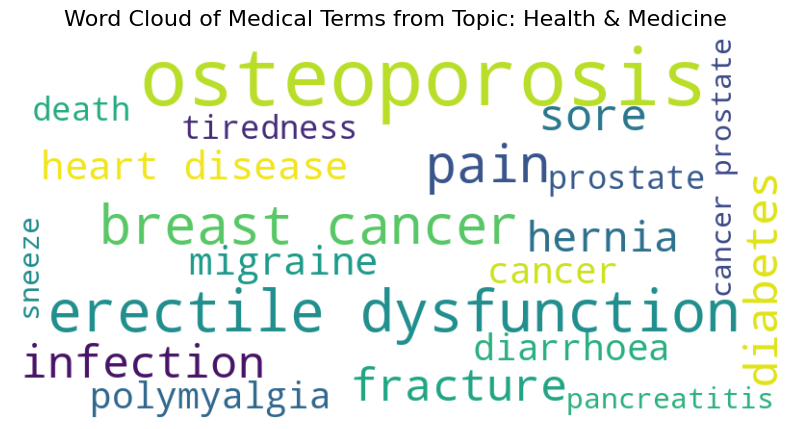

In [92]:
# Create the word cloud object using term frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20, colormap='viridis').generate_from_frequencies(medical_term_counts)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Medical Terms from Topic: Health & Medicine', fontsize=16)
plt.show()

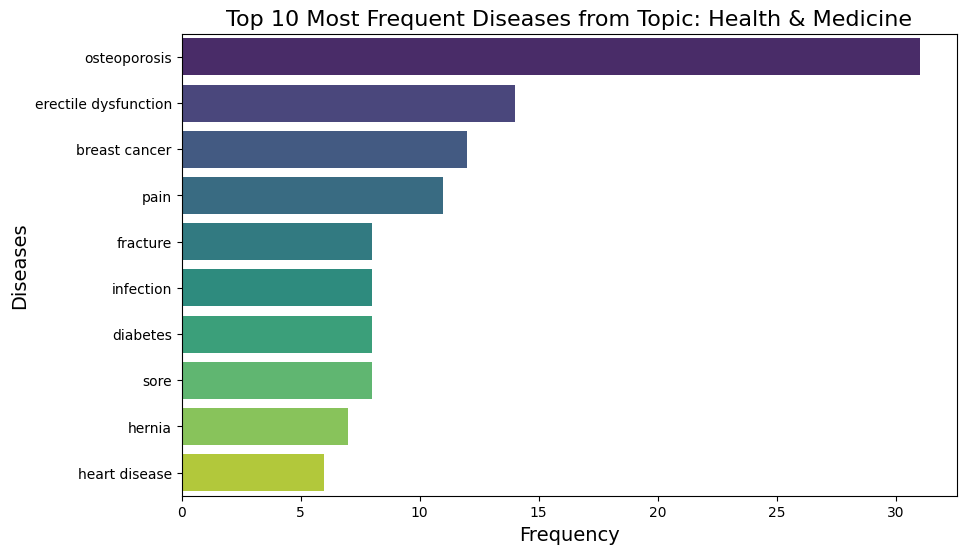

In [93]:
# # Count the frequency of each disease
# disease_counts = Counter(medical_terms)

# Get the top 10 most common diseases
top_10_diseases = medical_term_counts.most_common(10)

# Split the data into two lists: diseases and their counts
diseases, counts = zip(*top_10_diseases)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(diseases), palette='viridis')
plt.title('Top 10 Most Frequent Diseases from Topic: Health & Medicine', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Diseases', fontsize=14)
plt.show()


## Health Buzz: Osteoporosis and Erectile Dysfunction Lead the Medical Talk

#### In the 'Health & Medicine' discussions, **osteoporosis** stands out as the top concern, mentioned 31 times, signaling a strong focus on bone health. **Erectile dysfunction** and **breast cancer** follow with 14 and 12 mentions respectively, highlighting key issues in both men's and women's health.

#### Terms like **pain**, **fracture**, **infection**, and **diabetes** (each with 8-11 mentions) suggest that chronic conditions and common ailments are also at the forefront of these conversations. Rounding out the list, **hernia** and **heart disease** remind us that a wide range of health issues capture attention, reflecting the diverse medical concerns being actively discussed.


## How do key medical terms in the 'Health & Medicine' topic co-occur, and what are the significant relationships between them?

#### Network Graph Implementation

1. **Count Co-Occurrences**: Identify pairs of terms that appear together within the same document.

2. **Use Named Entity Recognition (NER)**: Apply the spaCy model to extract disease entities from the text.

3. **Create and Visualize Network Graph**: Use `networkx` to visualize these relationships, highlighting the most significant connections.



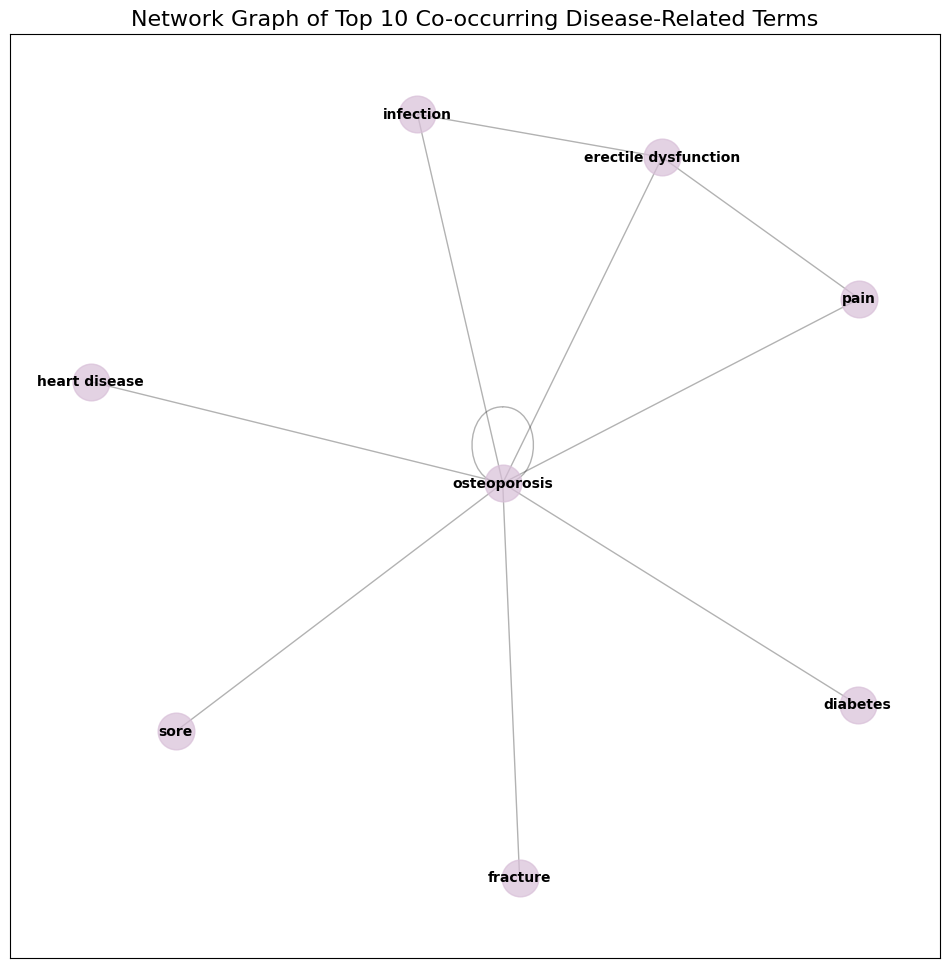

In [94]:
# Extract pairs of disease terms from each document
top_terms_pairs = []

for doc in health_documents:
    text = corpus_dict[doc]
    doc_entities = [ent.text for ent in nlp(text).ents if ent.label_ == 'DISEASE']

    # Generate all unique pairs of disease terms in the document
    pairs = list(combinations(doc_entities, 2))
    top_terms_pairs.extend(pairs)

# Count the frequency of each pair
pair_counts = Counter(top_terms_pairs)

# Define the number of top pairs to keep
N = 10

# Get the top N most common pairs
top_n_pairs = pair_counts.most_common(N)

# Extract just the pairs (without counts) for the network graph
top_terms_pairs = [pair for pair, count in top_n_pairs]

# Create the network graph
G = nx.Graph()

# Add edges to the graph
for term1, term2 in top_terms_pairs:
    G.add_edge(term1, term2)

# Apply a layout to the graph
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Draw the nodes, edges, and labels
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='#d8bfd8', alpha=0.7)

# Draw labels
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

plt.title('Network Graph of Top 10 Co-occurring Disease-Related Terms', fontsize=16)
plt.show()


## The Web of Health: Unraveling the Hidden Connections Between Diseases

#### This network graph brings to life the connections between diseases and conditions, emphasizing the importance of considering their broader implications as interconnected rather than isolated incidents.

####**Osteoporosis** stands out as a central node, linked to a wide range of issues including **fractures**, **heart disease**, and **diabetes**, indicating its broad impact on overall health. **Erectile dysfunction** also shows strong ties with conditions like **pain** and **infection**. The presence of shared symptoms like **sore** across multiple conditions emphasizes the interconnected nature of these health concerns.



## Which type of cancer sparks the most discussion in the 'Health & Medicine' topic?

**Implementation Technique**:
- Apply the **spaCy NER model** trained on biomedical corpus BIONLP13CG to extract cancer entities from the text.
- Perform frequency analysis on extracted cancer terms to identify the most discussed types.


In [95]:
import spacy
from collections import Counter

# Load the biomedical corpus
nlp = spacy.load("en_ner_bionlp13cg_md")

# List to store all cancer-related entities
cancer_terms = []

# Process each document in the health-related corpus
for doc_name in health_documents:
    if doc_name in corpus_dict:
        text = corpus_dict[doc_name]
        doc = nlp(text)
        # Extract cancer-related entities
        for ent in doc.ents:
            if ent.label_ == "CANCER":
                cancer_terms.append(ent.text)

# Remove the generic 'cancer' term from cancer_terms if it's present
# Reason: 'Cancer' is a broad term and doesn't provide specific insights compared to the more detailed cancer types.
if 'cancer' in cancer_terms:
    cancer_terms.remove('cancer')

# Count the frequency of each cancer type
cancer_count = Counter(cancer_terms)

# Find the most talked-about type of cancer
most_common_cancer = cancer_count.most_common(1)

# Display the result
print(f"The most talked-about type of cancer in health documents is: {most_common_cancer[0][0]} with {most_common_cancer[0][1]} mentions.")

The most talked-about type of cancer in health documents is: breast cancer with 12 mentions.


## Breast Cancer Takes Center Stage in Health Conversations

In the health-related discussions, **breast cancer** stands out as the most frequently mentioned cancer type. This reflects its prominent role in public health conversations and ongoing efforts in awareness, prevention, and treatment. Its frequent mention underscores the continued focus on breast cancer in medical discussions and community outreach.


## How are the concepts of education and funding discussed together, and what concerns or themes emerge from their intersection?

### Implementation for Concordance Analysis:

1. **Generate Concordances**: Identify occurrences of the word "education" in the text.

2. **Filter for Context**: From the generated concordances, filter out those that also contain the word "funding."

3. **Analyze Context**: Review the filtered concordances to understand how "education" and "funding" are discussed together, highlighting key themes or concerns.


In [96]:
# Get the list of documents associated with the "Literature & Education" topic (Topic 2)
education_documents = df[df['Topic'] == 2]['Document'].tolist()


# Initialize an empty list to hold the tokens
all_tokens = []

# Step 2: Extract the text from each document and add the tokens to the list
for doc_name in corpus_dict:
      text = corpus_dict[doc_name]
      tokens = nltk.word_tokenize(text)
      all_tokens.extend(tokens)

# Recreate the text object from the tokens
text_object = nltk.Text(all_tokens)

# Generate Concordances for "education"
concordance_list = text_object.concordance_list("education", width=80, lines=100)  # Collect concordances for "education"

# Step 5: Filter concordances based on the presence of "funding"
filtered_concordances = []
for concord in concordance_list:
    context = ' '.join(concord.left + concord.right)  # Combine left and right contexts
    if "funding" in context:
        filtered_concordances.append(concord.line)

# Step 6: Display the filtered concordances
print(f"Filtered Concordances Containing Both 'Education' and 'Funding':\n")
for line in filtered_concordances:
    print(line)


Filtered Concordances Containing Both 'Education' and 'Funding':

ack wanted put thought forward cut education university fee hecs funding though
 repercussion thought student free education feel urge obligation give somethin
ity brendan nelson expressed worry education paid tax working class perhaps pai
na support life basically doh help education help hospital medical dental life 


## HECS-HELP: A Lifeline or a Burden? Unpacking the Financial Strain of Education Funding

#### The filtered concordances highlight the ongoing concern about the financial burden of education, particularly focusing on the HECS-HELP system. HECS-HELP, a loan provided by the Australian Government to cover student contribution amounts, emerges as a central theme. The discussions underscore the tension between the accessibility of higher education and the financial strain it imposes on students, especially those from working-class backgrounds.

#### One excerpt discusses the impact of cutting education funding through university fees and the HECS-HELP scheme, reflecting worries about the long-term repercussions for students who rely on these loans to fund their education. The narrative suggests that while HECS-HELP offers a crucial financial lifeline, it also raises concerns about the debt burden carried by graduates and its potential effect on their future financial stability.


##  How do national, religious, and political groups interact within the 'Social Events & Interactions' topic, and which entities are most commonly linked together?

#### Network Graph Implementation

1. **Count Co-Occurrences**: Identify pairs of national, religious, and political groups that appear together within the same document.

2. **Use Named Entity Recognition (NER)**: Apply the spaCy model to extract these entities.

3. **Create and Visualize Network Graph**: Use `networkx` to visualize the interactions between these groups, focusing on the most frequently mentioned and co-occurring entities.

In [98]:
# Install the en_core_web_sm model for NER
!python -m spacy download en_core_web_sm
# Restart session after installing

2024-09-04 13:07:46.073044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 13:07:46.104761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 13:07:46.114439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 13:07:47.749275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl#egg=en_core_web_sm==3.0.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behavio

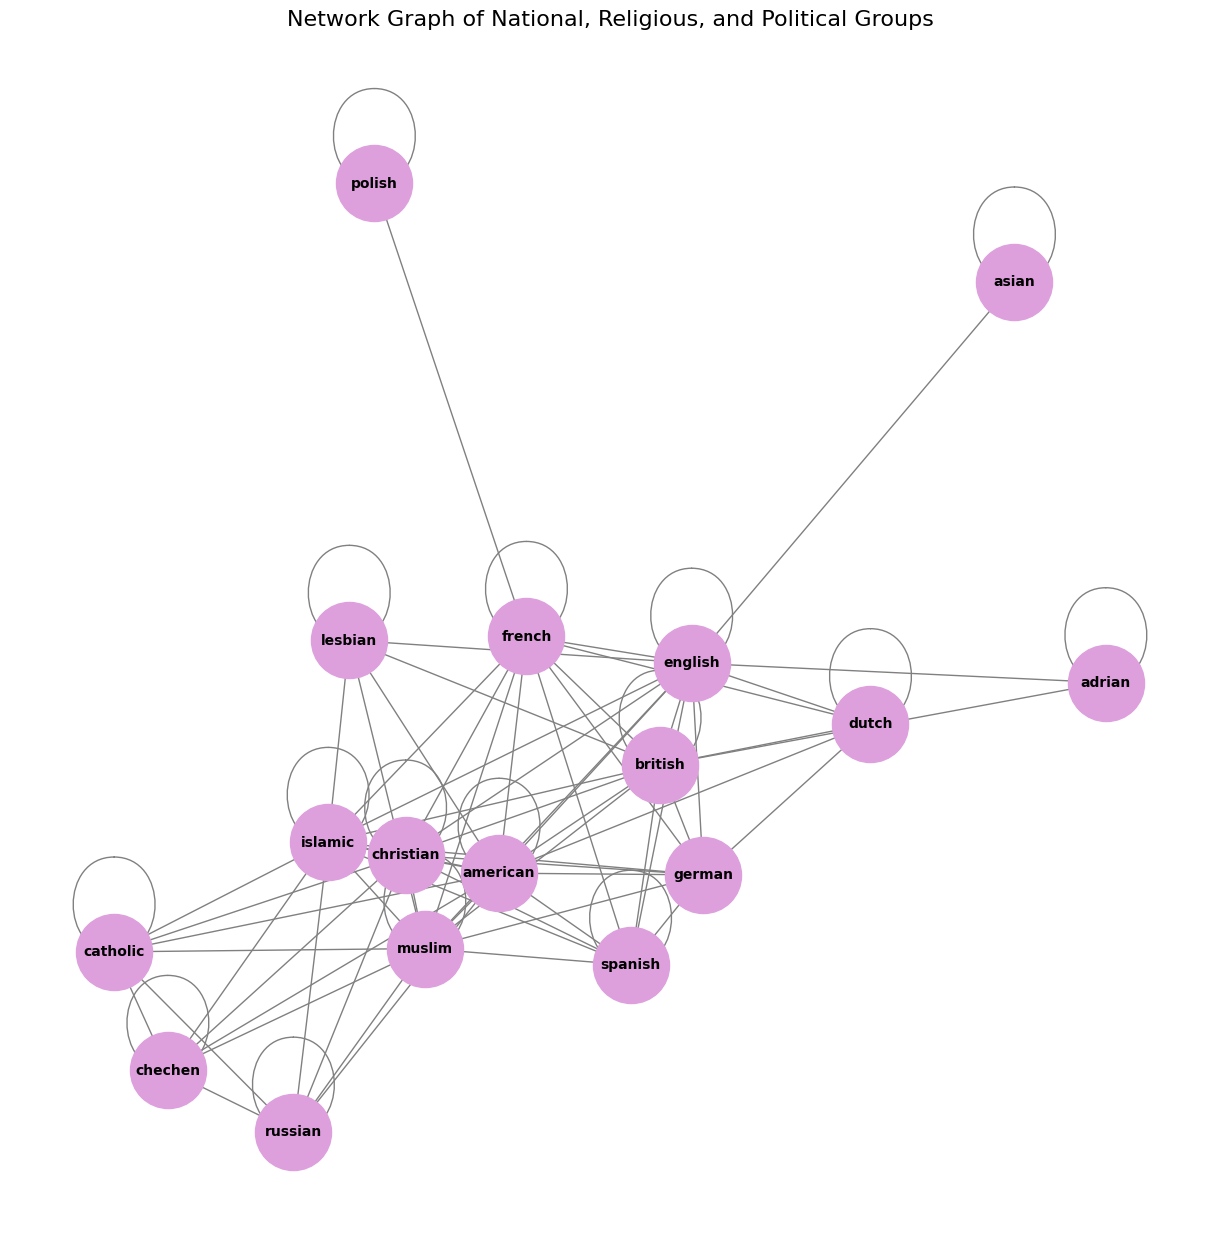

In [104]:
# Load spaCy's language model
nlp = spacy.load("en_core_web_sm")

# Count the frequency of NORP entities across all documents
norp_entity_counts = Counter()

# Collect NORP entities and count their occurrences
for doc_name, text in corpus_dict.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == "NORP"]
    norp_entity_counts.update(entities)

# Define a threshold for the minimum number of occurrences to include in the graph
min_occurrences = 5

# Create a filtered list of NORP entities that meet the threshold
filtered_norp_entities = {entity for entity, count in norp_entity_counts.items() if count >= min_occurrences}

# Create a new network graph and only include the filtered NORP entities
G = nx.Graph()

# Add edges between co-occurring filtered NORP entities
for doc_name, text in corpus_dict.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == "NORP"]
    # Filter the entities in this document by the frequency threshold
    entities = [entity for entity in entities if entity in filtered_norp_entities]

    for i, entity1 in enumerate(entities):
        for entity2 in entities[i+1:]:
            G.add_edge(entity1, entity2)

# Draw the filtered network graph
plt.figure(figsize=(10,8))

# Add seed to spring_layout to control node placement
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Drawing the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='plum', edge_color='gray', font_size=10, font_weight='bold')

plt.title('Network Graph of National, Religious, and Political Groups', fontsize=16)
plt.show()



## Crossroads of Identity: How Religion, Nationality, and Gender Intersect in Public Conversations

#### The network of national, religious, and political groups paints an interesting picture of social conversations. **American**, **British**, **Muslim**, **Islamic**, and **Christian** groups are at the heart of these discussions, often appearing together. This suggests that topics like international relations, politics, and religion frequently overlap when these groups are mentioned.

#### Religious identities, especially **Christian**, **Islamic**, and **Catholic**, come up together, showing that faith is a common theme in many of these talks. It's also notable that **Lesbian** is discussed alongside religious groups, hinting at ongoing conversations about gender and sexuality within these communities. Overall, this network highlights how different identities and beliefs come together in public discussions.


## How do plant preferences vary in the 'Gardening' topic, and which plants are mentioned most frequently across all documents?

**Implementation**:
- **Identify Key Plant Mentions**: Analyze the 'Gardening' topic documents to extract plant names using a predefined list of common plants.
- **Count Plant Frequencies**: Count occurrences of each plant across the 'Gardening' topic documents to understand the most popular mentions.
- **Create and Visualize Word Cloud**: Generate a word cloud to visually represent the most frequently mentioned plants in the 'Gardening' topic documents.

In [106]:
# Scrape plant names from the website
url = "https://www.bhg.com/gardening/plant-dictionary/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract plant names into a list
plant_list_items = soup.find_all('li', class_='mntl-link-list__item')
plant_names = [item.find('a').text.strip().lower() for item in plant_list_items]

# Display the list of scraped plant names
print(f"Extracted {len(plant_names)} plant names:")
print(plant_names)


# Get the list of documents associated with the "Gardening" topic (Topic 1)
gardening_documents = df[df['Topic'] == 1]['Document'].tolist()

# Initialize a dictionary to store plant terms found in each document
doc_plant_mentions = {}

# Check each gardening document for plant mentions
for doc in gardening_documents:
    if doc in corpus_dict:
        text = corpus_dict[doc]
        # Find plant names that appear in the document text
        plant_mentions = [plant for plant in plant_names if plant in text]
        doc_plant_mentions[doc] = plant_mentions

# Print documents and their corresponding plant terms
print("\nDocuments and the plant terms found in them:")
for doc, plants in doc_plant_mentions.items():
    print(f"Document: {doc}")
    print(f"Plant Terms: {', '.join(plants) if plants else 'No plant terms found'}")
    print("\n")


Extracted 378 plant names:
['african daisy', 'african violet', 'agapanthus', 'agave', 'ajuga', 'allium', 'aloe vera', 'alstroemeria', 'amaranth', 'amaryllis', 'anemone', "angel's trumpet", 'angelica', 'anise', 'arborvitae', 'arrowhead', 'artemisia', 'artichoke', 'arugula', 'ash', 'asparagus', 'asparagus fern', 'aspen', 'aster', 'astilbe', 'avocado', "baby's breath", "bachelor's button", 'bacopa', 'bald cypress', 'balloon flower', 'barberry', 'basil', 'bay', 'beautyberry', 'bee balm', 'beech', 'beet', 'begonia', 'bell pepper', 'bellflower', 'birch', 'bird of paradise', 'black pepper', 'black-eyed susan', 'blackberry', 'blanket flower', 'bleeding heart', 'bloodroot', 'bluebeard', 'blueberry', 'bluestar', 'borage', 'boston fern', 'bougainvillea', 'boxwood', 'bradford pear', 'broccoli', 'brussels sprouts', 'buckthorn', 'buttonbush', 'cabbage', 'caladium', 'calendula', 'calibrachoa', 'california poppy', 'camellia', 'canna', 'caraway', 'cardamom', 'carrot', 'castor bean', 'catmint', 'catnip'

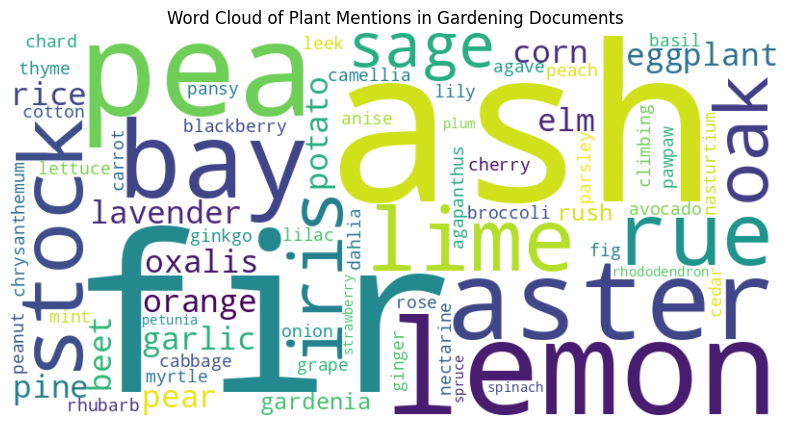

In [107]:
# Combine all plant terms from the documents into a single string
all_plant_mentions = [plant for plants in doc_plant_mentions.values() for plant in plants]
all_plant_mentions_text = ' '.join(all_plant_mentions)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_plant_mentions_text)

# SDisplay the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Plant Mentions in Gardening Documents')
plt.show()


## **What’s Growing in Australian Gardens?**

#### The word cloud analysis, based on plant mentions, highlights a clear dominance of **ash**, **fir**, **pea**, and **lemon**, each frequently mentioned, showcasing their widespread appeal in Australian gardens. **Bay**, **lime**, **aster**, **rue**, and **stock** are also prominent, reflecting a balanced focus on both evergreen trees and versatile plants. Additionally, edible plants like **eggplant**, **garlic**, and **potato** appear consistently, suggesting a strong trend toward growing home-produce. While less frequent, mentions of flowers such as **iris**, **lavender**, and **orange** add color and fragrance to the gardening landscape. This blend of plants highlights the diversity of gardening preferences across regions.


## How do plant preferences differ between the Eastern and Southern/Western regions in the 'Gardening' topic?

**Implementation**:
- **Categorize 'Gardening' Documents by Region**: Split the 'Gardening' topic documents based on Eastern and Southern/Western regions.

- **Count Regional Plant Mentions**: For each region, count the mentions of plant names to identify regional differences in plant preferences.

- **Create and Visualize Regional Bar Plots**: Generate two bar plots, one for the Eastern region and one for the Southern/Western region, showing the top 10 most mentioned plants in each area.


In [108]:
# Split documents based on the region
eastern_documents = df[df['Region'] == 'Eastern']['Document'].tolist()
southern_western_documents = df[df['Region'] == 'Southern/Western']['Document'].tolist()

# Initialize dictionaries for plant mentions per region
eastern_plant_mentions = []
southern_western_plant_mentions = []

# Check for plant mentions in each document for both regions
for doc in eastern_documents:
    if doc in corpus_dict:
        text = corpus_dict[doc]
        # Find plant names that appear in the document text
        plant_mentions = [plant for plant in plant_names if plant in text]
        eastern_plant_mentions.extend(plant_mentions)

for doc in southern_western_documents:
    if doc in corpus_dict:
        text = corpus_dict[doc]
        # Find plant names that appear in the document text
        plant_mentions = [plant for plant in plant_names if plant in text]
        southern_western_plant_mentions.extend(plant_mentions)

# Step 2: Create dataframes for both regions and calculate plant frequencies
eastern_plant_freq_df = pd.DataFrame(eastern_plant_mentions, columns=['Plant Name'])
southern_western_plant_freq_df = pd.DataFrame(southern_western_plant_mentions, columns=['Plant Name'])

# Frequency count for each region
eastern_plant_freq_counts = eastern_plant_freq_df['Plant Name'].value_counts()
southern_western_plant_freq_counts = southern_western_plant_freq_df['Plant Name'].value_counts()

# Step 3: Plot bar plots for the top 10 most mentioned plants in each region

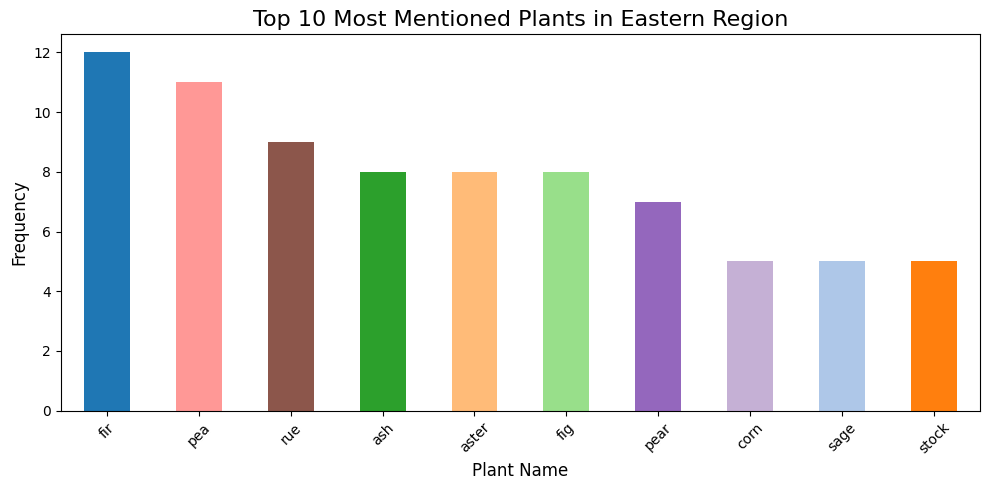

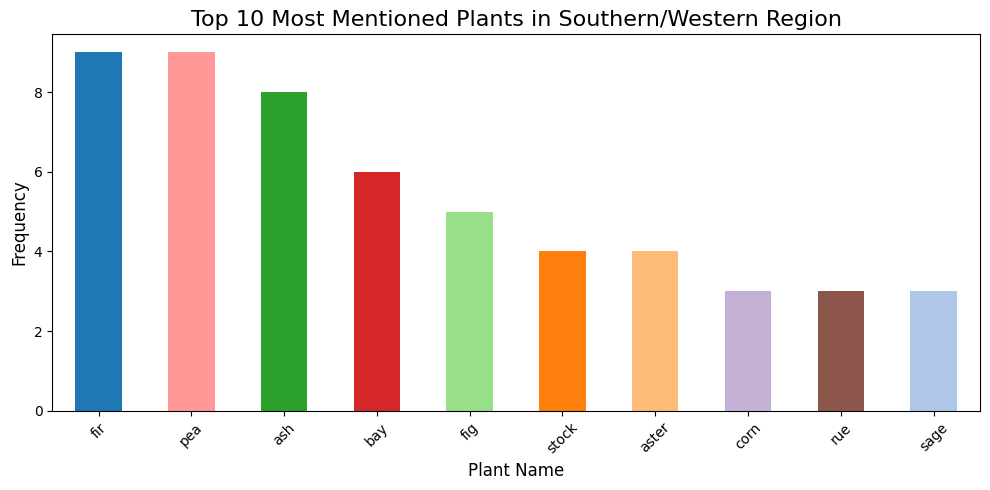

In [109]:
# Combine unique plant names from both regions
all_plants = list(set(eastern_plant_freq_counts.index[:10]).union(set(southern_western_plant_freq_counts.index[:10])))

# Generate a color palette based on the number of unique plants
palette = sns.color_palette('tab20', len(all_plants))

# Create a color mapping where each plant is assigned a color from the palette
color_mapping = dict(zip(all_plants, palette))

# Plot for Eastern region
plt.figure(figsize=(10, 5))
eastern_top_10 = eastern_plant_freq_counts.head(10)
eastern_colors = [color_mapping[plant] for plant in eastern_top_10.index]  # Use consistent colors
eastern_top_10.plot(kind='bar', color=eastern_colors)

plt.title('Top 10 Most Mentioned Plants in Eastern Region', fontsize=16)
plt.xlabel('Plant Name', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

# Plot for Southern/Western region
plt.figure(figsize=(10, 5))
southern_western_top_10 = southern_western_plant_freq_counts.head(10)
southern_western_colors = [color_mapping[plant] for plant in southern_western_top_10.index]
southern_western_top_10.plot(kind='bar', color=southern_western_colors)

plt.title('Top 10 Most Mentioned Plants in Southern/Western Region', fontsize=16)
plt.xlabel('Plant Name', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


## **Gardening Showdown: Eastern vs. Southern/Western Australia’s Favorite Plants**

When it comes to gardening, Eastern and Southern/Western Australia share a love for certain plants but reveal unique regional preferences that reflect both environmental and cultural distinctions.

#### **Shared Favorites: Fir, Pea, and Ash**
Both regions show a strong appreciation for **fir**, **pea**, and **ash** trees. The popularity of **pea** and **ash** across regions points to their ease of cultivation and versatility, making them staples in Australian gardens.

#### **Eastern Region: A Flourish of Color and Fruit**
The Eastern region, however, shows a distinctive tilt toward flowering plants and fruit trees. **Rue** and **aster** stand out, highlighting the region’s fondness for vibrant gardens with a mix of medicinal herbs and colorful blooms. Additionally, **pear** trees are more frequently mentioned in the East, suggesting a preference for fruit-bearing plants.

#### **Southern/Western Region: A Taste for the Culinary**
Meanwhile, gardeners in the Southern/Western region seem to favor practical plants like **bay**, used in cooking. While **fig** and **corn** make appearances in both regions, they’re less prominent in the West compared to the East.

### Project Limitations

- **Limited Dataset Scope**: The analysis was based on a finite number of Australian radio transcripts. This dataset may not fully capture the diversity of topics, regional differences, and colloquial expressions used across the entire country.
  

- **Colloquial Language Challenges**: While efforts were made to handle Australian slang and colloquialisms, certain expressions might not have been fully captured, potentially leading to incomplete or inaccurate analysis of conversational trends.

- **Geographical Limitations**: The division of topics by region (Eastern vs. Southern/Western) was simplified, and information about more localized areas or smaller regional differences may have been overlooked.

- **Focus on Specific Topics**: The analysis was focused on topics identified through NMF, potentially missing out on emerging or less-discussed topics.

### Future Work

- **Expanding the Dataset**: Collecting and analyzing more radio transcripts from a wider range of sources and regions would allow for a more comprehensive understanding of national and regional trends in conversations.

- **Improving Language Processing for Colloquial Speech**: Developing or fine-tuning NER models specifically for conversational and colloquial Australian English could improve entity recognition and the handling of informal language.

- **Incorporating Sentiment Analysis**: Future work could include sentiment analysis to capture the emotional tone of conversations, adding another layer of insight into how topics like health are perceived by the public.

- **Topic Modeling on a Broader Range of Themes**: Expanding topic modeling to include emerging themes and topics not previously considered, such as environmental issues or political discourse, could reveal new insights.
